In [1]:
# Assuming your target variable (labels) is in a column called 'Label'
import pandas as pd

# Load your dataset (replace with your actual file or DataFrame)
df_balanced= pd.read_csv('/kaggle/input/yonatanazeb/HateSpeechDatasetBalanced.csv')

# Check the distribution of the target variable
class_distribution = df_balanced['Label'].value_counts()

# Display the distribution
print(class_distribution)

# Optionally, display the distribution as percentages
class_percentage = df_balanced['Label'].value_counts(normalize=True) * 100
print(class_percentage)


Label
1    364525
0    361594
Name: count, dtype: int64
Label
1    50.201826
0    49.798174
Name: proportion, dtype: float64


In [2]:
df_balanced.isna().sum()

Content    0
Label      0
dtype: int64

In [3]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [4]:
df_balanced.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


<Axes: xlabel='Label', ylabel='count'>

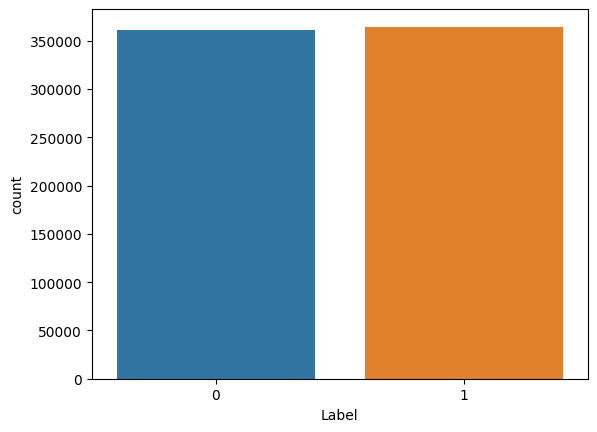

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='Label', data=df_balanced)

In [6]:
#cleaning the data set
import re
import pandas as pd

def remove_tags(text):
    return re.sub(r'<.*?>', '', text)

def preprocess_text(sen):
    # Removing HTML tags
    sentence = remove_tags(sen)

    # Removing all punctuations and numbers, keeping only alphabets
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing single characters (isolated letters)
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)

    # Replacing multiple spaces with a single space
    sentence = re.sub(r'\s+', ' ', sentence)

    # Stripping leading and trailing spaces
    sentence = sentence.strip()

    # Lowercase the sentence
    sentence = sentence.lower()

    return sentence

def text_preprocessing(df_balanced, col_name):
    # Apply the preprocessing function to the column without a progress bar
    df_balanced[col_name] = df_balanced[col_name].apply(preprocess_text)
    
    return df_balanced


In [7]:
df_balanced['Length'] = df_balanced.Content.apply(lambda x:len(x))

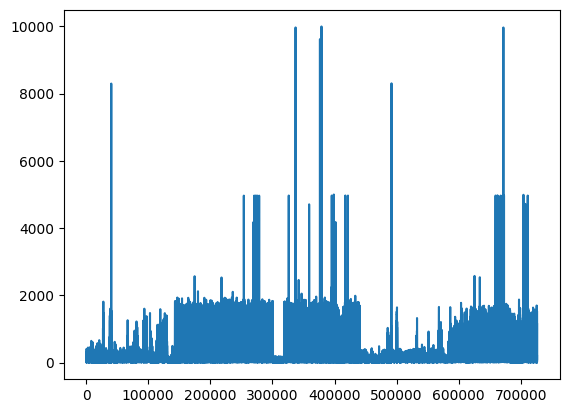

In [8]:
plt.plot(df_balanced.Length)
plt.show()

In [9]:
df_balanced.Length.max()

9998

In [10]:
df_balanced.describe()

,Label,Length
count,726119.000000,726119.000000
mean,0.502018,196.847952
std,0.499996,247.351120
min,0.000000,1.000000
25%,0.000000,59.000000
50%,1.000000,109.000000
75%,1.000000,228.000000
max,1.000000,9998.000000


In [11]:
df_cleaned = text_preprocessing(df_balanced, 'Content')

In [12]:
df_cleaned.head()

,Content,Label,Length
0,denial of normal the con be asked to comment o...,1,77
1,just by being able to tweet this insufferable ...,1,85
2,that is retarded you too cute to be single tha...,1,55
3,thought of real badass mongol style declaratio...,1,106
4,afro american basho,1,19


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
num_words = 20000 # this means 10000 unique words can be taken 
tokenizer=Tokenizer(num_words,lower=True)
tokenizer.fit_on_texts(df_cleaned['Content'])


In [15]:
len(tokenizer.word_index) # this is whole unique words in our corpus
# but we are taking only 10000 words in our model

136667

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

# Define features and target
X = df_cleaned['Content']  # Features (text data)
y = df_cleaned['Label']  # Target (labels)

# First, split the data into training and temp sets (80% train, 20% temp for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temp set into validation and test sets (50% of temp for validation, 50% for test)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize and fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=20000, lower=True)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)  # Convert training texts to sequences
X_val_seq = tokenizer.texts_to_sequences(X_val)      # Convert validation texts to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)    # Convert test texts to sequences

# Pad sequences
maxlen = 224  # Define the maximum length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')  # Pad training sequences
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')      # Pad validation sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')    # Pad test sequences

# Convert labels to one-hot encoding
num_classes = 3  # Set this to the number of classes in your dataset (since you have 3 classes)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Now you have:
# X_train_pad, y_train_one_hot (for training)
# X_val_pad, y_val_one_hot (for validation)
# X_test_pad, y_test_one_hot (for testing)


In [17]:
print(X_train_pad.shape, X_val_pad.shape)

(580895, 224) (72612, 224)


In [18]:
import gensim.downloader as api

# Load 300-dimensional GloVe model from Gensim's data repository
glove_gensim = api.load('glove-wiki-gigaword-50') # 300 dimension


[==================================================] 100.0% 66.0/66.0MB downloaded


In [19]:
glove_gensim['dog'].shape[0]

50

In [20]:
import numpy as np

In [21]:
vector_size = 50
gensim_weight_matrix = np.zeros((num_words, vector_size))
gensim_weight_matrix.shape

for word, index in tokenizer.word_index.items():
    if index < num_words:  # since index starts with zero 
        if word in glove_gensim.key_to_index:
            gensim_weight_matrix[index] = glove_gensim[word]
        else:
            gensim_weight_matrix[index] = np.zeros(50)

In [22]:
gensim_weight_matrix.shape

(20000, 50)

In [23]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GRU
from tensorflow.keras.layers import Dropout

In [24]:
EMBEDDING_DIM = 50 # this means the embedding layer will create  a vector in 300 dimension
model = Sequential()
model.add(Embedding(input_dim = num_words,# the whole vocabulary size 
                          output_dim = EMBEDDING_DIM, # vector space dimension
                          input_length= X_train_pad.shape[1], # max_len of text sequence
                          weights = [gensim_weight_matrix],trainable = False))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [26]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.keras', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [27]:
history_embedding = model.fit(X_train_pad,y_train_one_hot, epochs = 50, batch_size = 128, validation_data=(X_val_pad, y_val_one_hot),verbose = 2, callbacks= [es, mc]  )

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.81802, saving model to ./model.keras
4539/4539 - 655s - 144ms/step - accuracy: 0.7801 - loss: 0.3041 - val_accuracy: 0.8180 - val_loss: 0.2627
Epoch 2/50

Epoch 2: val_accuracy improved from 0.81802 to 0.83249, saving model to ./model.keras
4539/4539 - 653s - 144ms/step - accuracy: 0.8156 - loss: 0.2649 - val_accuracy: 0.8325 - val_loss: 0.2432
Epoch 3/50

Epoch 3: val_accuracy improved from 0.83249 to 0.83932, saving model to ./model.keras
4539/4539 - 653s - 144ms/step - accuracy: 0.8269 - loss: 0.2496 - val_accuracy: 0.8393 - val_loss: 0.2348
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.83932
4539/4539 - 653s - 144ms/step - accuracy: 0.8352 - loss: 0.2391 - val_accuracy: 0.8390 - val_loss: 0.2311
Epoch 5/50

Epoch 5: val_accuracy improved from 0.83932 to 0.85022, saving model to ./model.keras
4539/4539 - 654s - 144ms/step - accuracy: 0.8416 - loss: 0.2303 - val_accuracy: 0.8502 - val_loss: 0.2200
Epoch 6/50

Epoch 

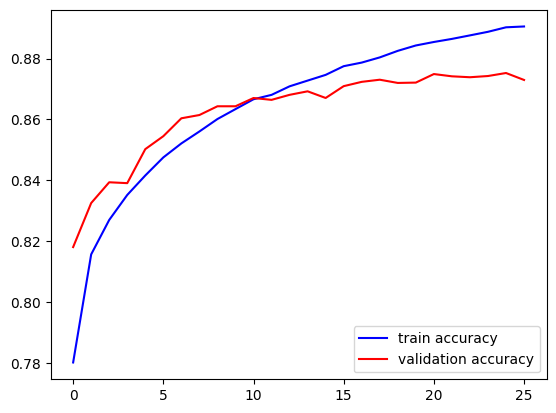

In [28]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [29]:
model.evaluate(X_test_pad, y_test_one_hot) 

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 52s 23ms/step - accuracy: 0.8729 - loss: 0.1952


[0.1956947296857834, 0.8720872402191162]

In [30]:
y_pred =   np.argmax(model.predict(X_test_pad), axis  =  1)

2270/2270 ━━━━━━━━━━━━━━━━━━━━ 50s 22ms/step


In [31]:
y_true = np.argmax(y_test_one_hot, axis = 1)


In [32]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     35902
           1       0.87      0.87      0.87     36710

    accuracy                           0.87     72612
   macro avg       0.87      0.87      0.87     72612
weighted avg       0.87      0.87      0.87     72612



In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [33]:
from sklearn.metrics import confusion_matrix

# Assuming y_true are the actual labels and y_pred are the predicted labels
conf_matrix = confusion_matrix(y_true, y_pred)

print(conf_matrix)


[[31285  4671]
 [ 4617 32039]]


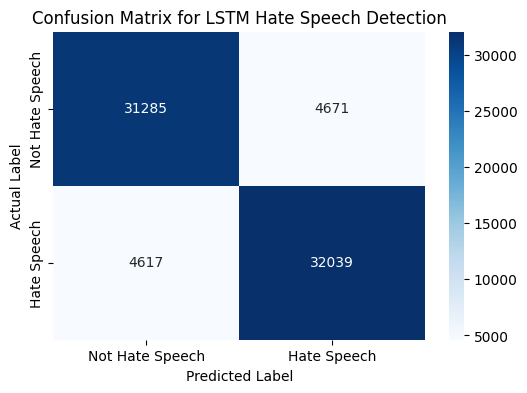

                 precision    recall  f1-score   support

Not Hate Speech       0.87      0.87      0.87     35956
    Hate Speech       0.87      0.87      0.87     36656

       accuracy                           0.87     72612
      macro avg       0.87      0.87      0.87     72612
   weighted avg       0.87      0.87      0.87     72612



In [41]:
from sklearn.metrics import classification_report
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate Speech', 'Hate Speech'], 
            yticklabels=['Not Hate Speech', 'Hate Speech'])

plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for LSTM Hate Speech Detection')
plt.show()

# Classification report for additional metrics
print(classification_report(y_true, y_pred, target_names=['Not Hate Speech', 'Hate Speech']))

In [34]:
# Assuming these are the labels for hate speech detection
def get_key(value):
    dictionary = {0: 'Not Hate Speech', 1: 'Hate speech'}
    return dictionary.get(value, None)


In [35]:
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=224,padding='post')
    #ans=get_key(model.predict_classes(sentence_padded))
    ans=get_key(np.argmax(model.predict(sentence_padded)))
    print("The emotion predicted is",ans)

In [52]:
predict(str(input('Enter a sentence : ')))


Enter a sentence :  I believe that everyone should be treated equally, regardless of their background.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The emotion predicted is Not Hate Speech


In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 224, 50)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 224, 200)       │       120,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 224, 400)       │       641,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 224, 400)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 200)            │       400,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,491,411 (17.13 MB)

 Trainable params: 1,163,803 (4.44 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 2,327,608 (8.88 MB)